## Import và tải dữ liệu

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1


### Import các thư viện cần thiết

In [2]:
import os
import torch
import random
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet50_Weights

In [3]:
annotations_dir = os.path.join(path, 'annotations')
images_dir = os.path.join(path, 'images')
print(annotations_dir)
print(images_dir)

/root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1/annotations
/root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1/images


In [4]:
def filter_images_multi_objects(images_dir, annotations_dir):
    image_files = []
    for img_file in os.listdir(images_dir):
        img_name = os.path.splitext(img_file)[0]
        annotation_file = os.path.join(annotations_dir, img_name+'.xml')
        num_obj = count_num_object(annotation_file)
        if num_obj >= 1:
            image_files.append(img_file)
    return image_files

def count_num_object(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()
    count = 0
    for obj in root.findall('object'):
        count += 1
    return count

In [5]:
dataset = filter_images_multi_objects(images_dir, annotations_dir)
print(len(dataset))

3686


In [6]:
train_ds, val_ds = train_test_split(dataset,
                                    test_size=0.2,
                                    random_state=42)

In [7]:
class ImageDataset(Dataset):
    def __init__(self, dataset, images_dir, annotations_dir, transform=None):
        super().__init__()
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.image_files = dataset

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        label = None
        height = int(root.find('size/height').text)
        width = int(root.find('size/width').text)
        for obj in root.findall('object'):
            if label is None:
                label = obj.find('name').text

            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)

            bbox = [
                xmin / width,
                ymin / height,
                xmax / width,
                ymax / height
            ]
        label = 0 if label == 'cat' else 1 if label == 'dog' else -1
        return label, torch.tensor(bbox, dtype=torch.float32)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # image 1
        img1_file = self.image_files[idx]
        img1_path = os.path.join(self.images_dir, img1_file)

        annotation1_file = os.path.splitext(img1_file)[0]+'.xml'
        image1_annotations = self.parse_annotation(os.path.join(self.annotations_dir, annotation1_file))

        # image 2
        idx2 = random.randint(0, len(self.image_files) - 1)
        img2_file = self.image_files[idx2]
        img2_path = os.path.join(self.images_dir, img2_file)

        # annotation file
        annotation2_file = os.path.splitext(img2_file)[0]+'.xml'
        image2_annotations = self.parse_annotation(os.path.join(self.annotations_dir, annotation2_file)) # parse annotations của image2

        image1 = Image.open(img1_path).convert('RGB')
        image2 = Image.open(img2_path).convert('RGB')

        # Horizontal merge
        merged_image = Image.new(
            'RGB',
            (image1.width + image2.width, max(image1.height, image2.height))
        )
        merged_image.paste(image1, (0, 0))
        merged_image.paste(image2, (image1.width, 0))
        merged_w = image1.width + image2.width
        merged_h = max(image1.height, image2.height)

        merged_annotations = []
        merged_annotations.append(
            {
                'bbox': image1_annotations[1].tolist(),
                'label': image1_annotations[0]
            }
        )
        new_bbox = [
            (image2_annotations[1][0] * image2.width + image1.width) / merged_w, # image2_annotations[1][0] * image2.width: chuẩn hóa về tọa độ thực tế
            (image2_annotations[1][1] * image2.height) / merged_h,
            (image2_annotations[1][2] * image2.width + image1.width) / merged_w,
            (image2_annotations[1][3] * image2.height) / merged_h,
        ]
        merged_annotations.append({
            'bbox': new_bbox,
            'label': image2_annotations[0]
        })

        # convert merged image to tensor
        if self.transform:
            merged_image = self.transform(merged_image)
        else:
            merged_image = transforms.ToTensor()(merged_image)

        annotations = torch.zeros((len(merged_annotations), 5))
        for i, ann in enumerate(merged_annotations):
            annotations[i] = torch.cat((torch.tensor(ann['bbox']), torch.tensor([ann['label']])))

        return merged_image, annotations


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ImageDataset(train_ds,
                             images_dir,
                             annotations_dir,
                             transform)
val_dataset = ImageDataset(val_ds,
                             images_dir,
                             annotations_dir,
                             transform)

train_loader = DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=128,
                        shuffle=False)

In [9]:
class SimpleYOLO(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.num_classes = num_classes

        # Remove the final classification layer of ResNet
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

        # Add the YOLO head
        self.fcs = nn.Linear(
            2048, 2*2*(4 + self.num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        features = nn.functional.adaptive_avg_pool2d(features, (1, 1)) # shape: (batch_size, 2048, 11, 1)
        features = features.view(features.size(0), -1) # shape: (batch_size, 2048)
        features = self.fcs(features)
        return features

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_to_idx = {'dog': 0, 'cat': 1}
num_classes = 2

model = SimpleYOLO(num_classes)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
def calculate_loss(output, targets, device, num_classes):
    mse_loss = nn.MSELoss()
    ce_loss = nn.CrossEntropyLoss()

    batch_size = output.shape[0]
    total_loss = 0

    output = output.view(batch_size, 2, 2, 4 + num_classes) # Reshape to (batch_size, grid_y, grid_x, 4 + num_classes)

    for i in range(batch_size):
        for j in range(len(targets[i])):
            # Determine which grid cell the object's center falls into
            # Assuming bbox coordinates are normalized to [0, 1]
            bbox_center_x = (targets[i][j][0] + targets[i][j][2]) / 2
            bbox_center_y = (targets[i][j][1] + targets[i][j][3]) / 2

            grid_x = int(bbox_center_x * 2) # multiply by number of grid cells
            grid_y = int(bbox_center_y * 2)

            # 1. Classification loss for the responsible grid cell
            # Convert label to one-hot encoding only for this example
            label_one_hot = torch.zeros(num_classes, device=device)
            label_one_hot[int(targets[i][j][4])] = 1

            # classification loss
            classification_loss = ce_loss(output[i, grid_y, grid_x, 4:], label_one_hot)

            # 2. Regression loss for the responsible grid cell
            bbox_target = targets[i][j][:4].to(device)
            regression_loss = mse_loss(output[i, grid_y, grid_x, :4], bbox_target)

            # 3. No Object Loss (for other grid cells)
            no_obj_loss = 0
            for other_grid_y in range(2):
                for other_grid_x in range(2):
                    if other_grid_y != grid_y or other_grid_x != grid_x:
                        # MSE loss for predicting no object (all zeros)
                        no_obj_loss += mse_loss(output[i, other_grid_y, other_grid_x, :4], torch.zeros(4, device=device))

            total_loss += classification_loss + regression_loss + no_obj_loss

    return total_loss / batch_size

In [12]:
def evaluate_model(model, data_loader, device, num_classes):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in tqdm.tqdm(data_loader, desc='Validation', leave=False):
            images = images.to(device)
            output = model(images)

            total_loss = calculate_loss(output, targets, device, num_classes)
            running_loss += total_loss.item()

            # Reshape output to (batch_size, grid_y, grid_x, 4 + num_classes)
            output = output.view(images.shape[0], 2, 2, 4 + num_classes)

            # Collect predictions and targtes for mAP calculation
            for batch_idx in range(images.shape[0]):
                for target in targets[batch_idx]:
                    # Determine responsible grid cell
                    bbox_center_x = (target[0] + target[2]) / 2
                    bbox_center_y = (target[1] + target[3]) / 2
                    grid_x = int(bbox_center_x * 2)
                    grid_y = int(bbox_center_y * 2)

                    # class prediction (index of max probability)
                    prediction = output[batch_idx, grid_y, grid_x, 4:].argmax().item()
                    all_predictions.append(prediction)
                    all_targets.append(target[4].item())
    val_loss = running_loss / len(data_loader)

    # convert lists to tensors for pytorch's metric functions
    all_predictions = torch.tensor(all_predictions, device=device)
    all_targets = torch.tensor(all_targets, device=device)

    # Calculate acc
    val_accuracy = (all_predictions == all_targets).float().mean()

    return val_loss, val_accuracy.item()

In [13]:
def train(model, train_loader, val_loader, optimizer, device, num_classes, epochs=30):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_accuracy = 0.0

    for epoch in tqdm.tqdm(range(epochs), desc='Epochs'):
        model.train()
        running_loss = 0.0

        for images, targets in tqdm.tqdm(train_loader, desc='Batches', leave=False):
            images = images.to(device)

            optimizer.zero_grad()
            output = model(images)

            total_loss = calculate_loss(output, targets, device, num_classes)
            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validation
        val_loss, val_accuracy = evaluate_model(model, val_loader, device, num_classes)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{epochs}\tTrain Loss: {epoch_loss:.4f},'
              f'\tValidation Loss: {val_loss:.4f}\tValidation Accuracy: {val_accuracy:.4f}')

        # save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [14]:
train(model, train_loader, val_loader, optimizer, device, num_classes, epochs=10)

Batches: 100%|██████████| 24/24 [01:28<00:00,  2.62s/it]
                                                        
Validation: 100%|██████████| 6/6 [00:16<00:00,  2.61s/it]
                                                         

Epoch 1/10	Train Loss: 1.2434,	Validation Loss: 2.4225	Validation Accuracy: 0.6247


Batches: 100%|██████████| 24/24 [01:29<00:00,  2.73s/it]
                                                        
Validation: 100%|██████████| 6/6 [00:16<00:00,  2.62s/it]
                                                         

Epoch 2/10	Train Loss: 0.9181,	Validation Loss: 0.9547	Validation Accuracy: 0.8577


Batches: 100%|██████████| 24/24 [01:26<00:00,  2.75s/it]
                                                        
Epochs:  30%|███       | 3/10 [05:13<12:09, 104.21s/it]

Epoch 3/10	Train Loss: 0.8183,	Validation Loss: 1.2824	Validation Accuracy: 0.8069



Batches: 100%|██████████| 24/24 [01:26<00:00,  2.74s/it]
                                                        
Epochs:  40%|████      | 4/10 [06:55<10:19, 103.27s/it]

Epoch 4/10	Train Loss: 0.7073,	Validation Loss: 0.9247	Validation Accuracy: 0.8462



Batches: 100%|██████████| 24/24 [01:26<00:00,  2.64s/it]
                                                        
Epochs:  50%|█████     | 5/10 [08:37<08:33, 102.74s/it]

Epoch 5/10	Train Loss: 0.7334,	Validation Loss: 1.0368	Validation Accuracy: 0.8482



Batches: 100%|██████████| 24/24 [01:26<00:00,  2.69s/it]
                                                        
Validation: 100%|██████████| 6/6 [00:15<00:00,  2.46s/it]
                                                         

Epoch 6/10	Train Loss: 0.7745,	Validation Loss: 0.9274	Validation Accuracy: 0.8604


Batches: 100%|██████████| 24/24 [01:26<00:00,  2.72s/it]
                                                        
Epochs:  70%|███████   | 7/10 [12:00<05:06, 102.20s/it]

Epoch 7/10	Train Loss: 0.7272,	Validation Loss: 0.9443	Validation Accuracy: 0.8469



Batches: 100%|██████████| 24/24 [01:27<00:00,  2.77s/it]
                                                        
Epochs:  80%|████████  | 8/10 [13:43<03:24, 102.22s/it]

Epoch 8/10	Train Loss: 0.7056,	Validation Loss: 1.0845	Validation Accuracy: 0.8103



Batches: 100%|██████████| 24/24 [01:26<00:00,  2.81s/it]
                                                        
Epochs:  90%|█████████ | 9/10 [15:25<01:42, 102.11s/it]

Epoch 9/10	Train Loss: 0.8173,	Validation Loss: 1.2556	Validation Accuracy: 0.8157



Batches: 100%|██████████| 24/24 [01:25<00:00,  2.62s/it]
                                                        
Epochs: 100%|██████████| 10/10 [17:07<00:00, 102.72s/it]

Epoch 10/10	Train Loss: 0.8066,	Validation Loss: 0.9919	Validation Accuracy: 0.8415


([1.2433970073858898,
  0.918131873011589,
  0.8182913437485695,
  0.7072773091495037,
  0.7334411218762398,
  0.7744788328806559,
  0.7271888429919878,
  0.7055687258640925,
  0.8172998403509458,
  0.8065969124436378],
 [2.4224775234858194,
  0.9547106524308523,
  1.2823591232299805,
  0.9247340162595113,
  1.0368349353472393,
  0.9273935357729594,
  0.9442947705586752,
  1.0844883521397908,
  1.255564312140147,
  0.9918798307577769],
 [],
 [0.6246612668037415,
  0.857723593711853,
  0.8069105744361877,
  0.8462059497833252,
  0.8482385277748108,
  0.8604336380958557,
  0.8468834757804871,
  0.8102981448173523,
  0.8157181739807129,
  0.8414634466171265])

In [15]:
def inference(model, image_path, transform, device, class_to_idx, threshold=0.5):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    original_width, original_height = image.size

    resized_image = image.resize((448, 448))
    resized_width, resized_height = resized_image.size

    # Apply the same transformations used during training
    transformed_image = transform(resized_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(transformed_image)
        output = output.view(1, 2, 2, 4 + len(class_to_idx))
    fig, ax = plt.subplots(1)
    ax.axis('off')
    ax.imshow(resized_image)

    for grid_y in range(2):
        for grid_x in range(2):
            # get the class prediction and bounding box for the current grid cell
            class_pred = output[0, grid_y, grid_x, 4:].argmax().item()
            bbox = output[0, grid_y, grid_x, :4].tolist()

            # Confidence
            confidence = torch.softmax(output[0, grid_y, grid_x, 4:], dim=0)[class_pred].item()

            # Scale the bounding box to the resized image size
            # Assuming bbox coordinates are normalized to [0, 1] within the grid cell
            x_min = bbox[0] * (resized_width / 2) + grid_x * (resized_width / 2)
            y_min = bbox[1] * (resized_height / 2) + grid_y * (resized_height / 2)
            x_max = bbox[2] * (resized_width / 2) + grid_x * (resized_width / 2)
            y_max = bbox[3] * (resized_height / 2) + grid_y * (resized_height / 2)

            # Draw the bounding box and label on the image if confidence is above threshold
            if confidence > threshold:
                rect = patches.Rectangle(
                    (x_min, y_min),
                    x_max - x_min,
                    y_max - y_min,
                    linewidth=1,
                    edgecolor='r',
                    facecolor='none'
                )
                ax.add_patch(rect)
                plt.text(x_min, y_min,
                         f'{list(class_to_idx.keys())[class_pred]}:{confidence:.2f}',
                         color='white',
                         fontsize=12,
                         bbox=dict(facecolor='red', alpha=0.5)
                )

<ipython-input-16-2a597d57c54e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


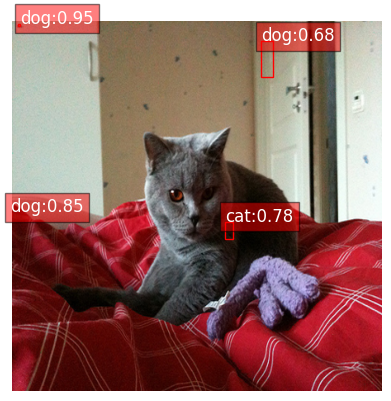

In [16]:
model.load_state_dict(torch.load('best_model.pth'))

# Inference
img_name = 'Cats_Test1002.png'
image_path = os.path.join(images_dir, img_name)
inference(model, image_path, transform, device, class_to_idx, threshold=0.5)